<a href="https://colab.research.google.com/github/MaricelaMH/SIMULACION-II/blob/main/PRUEBA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install simpy

Número estimado de combis necesarias: 1.26
Persona-1 llegó a las 1.44 minutos
Persona-2 llegó a las 6.29 minutos
Persona-3 llegó a las 7.13 minutos
Persona-4 llegó a las 8.45 minutos
Persona-5 llegó a las 14.42 minutos
Persona-6 llegó a las 16.25 minutos
Persona-7 llegó a las 17.43 minutos
Persona-8 llegó a las 26.71 minutos
Persona-9 llegó a las 28.25 minutos
Combi-1 llegó a las 30.44 minutos
Persona-1 subió a la Combi-1 después de 29.00 minutos de espera
Persona-2 subió a la Combi-1 después de 24.15 minutos de espera
Persona-3 subió a la Combi-1 después de 23.31 minutos de espera
Persona-4 subió a la Combi-1 después de 21.99 minutos de espera
Persona-5 subió a la Combi-1 después de 16.02 minutos de espera
Persona-6 subió a la Combi-1 después de 14.19 minutos de espera
Persona-7 subió a la Combi-1 después de 13.01 minutos de espera
Persona-8 subió a la Combi-1 después de 3.73 minutos de espera
Persona-9 subió a la Combi-1 después de 2.19 minutos de espera
Combi-1 se fue con 9 personas

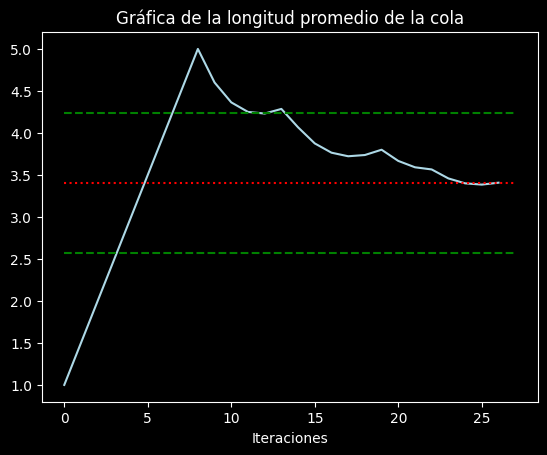

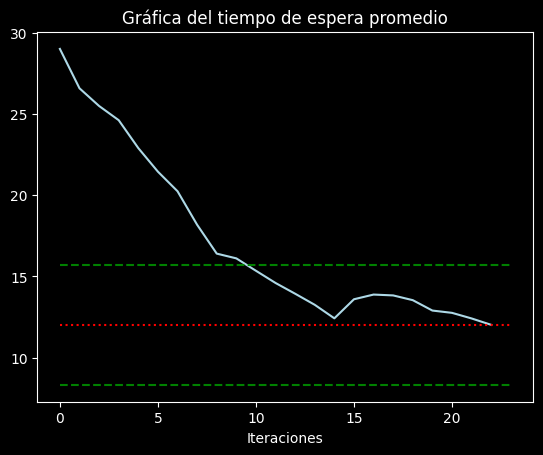

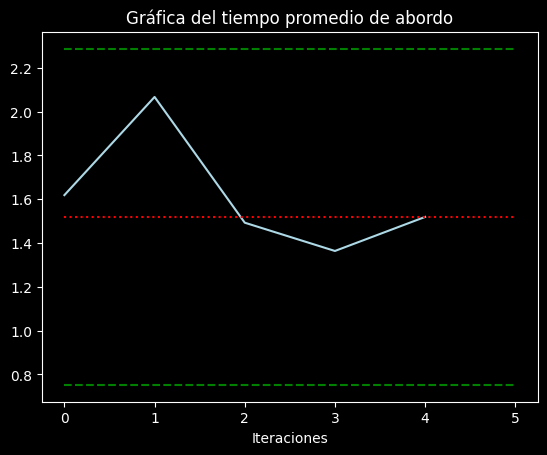

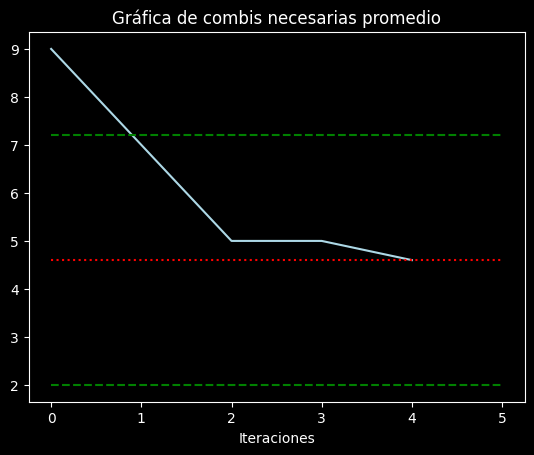

In [ ]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la simulación
TIEMPO_LLEGADA_PERSONA = 5  # Promedio de llegada de personas (en minutos)
TIEMPO_LLEGADA_COMBI = 20   # Promedio de llegada de combis (en minutos)
CAPACIDAD_COMBI = 19        # Capacidad máxima de pasajeros por combi
SIMULACION_TEMPO = 120      # Duración de la simulación (en minutos)

# Listas para almacenar las métricas
longitudes_cola = []
tiempos_espera = []
tiempos_abordo = []
combis_necesarias = []  # Lista para la cantidad de combis necesarias

def llegada_persona(env, cola_personas, persona_llegada):
    """Función para simular la llegada de personas."""
    persona_id = 1  # Para asignar un número único a cada persona
    while True:
        # El tiempo de llegada sigue una distribución exponencial
        tiempo_llegada = random.expovariate(1 / TIEMPO_LLEGADA_PERSONA)
        yield env.timeout(tiempo_llegada)
        persona = f'Persona-{persona_id}'
        print(f'{persona} llegó a las {env.now:.2f} minutos')
        cola_personas.put((persona, env.now))  # Guardamos el tiempo de llegada de la persona
        persona_llegada.append(env.now)  # Guardamos el tiempo de llegada
        persona_id += 1  # Incrementar el ID de la persona
        # Actualizar la longitud de la cola
        longitudes_cola.append(len(cola_personas.items))

def llegada_combi(env, cola_personas, combis, persona_llegada):
    """Función para simular la llegada de combis."""
    combi_id = 1  # Para asignar un número único a cada combi
    while True:
        # El tiempo de llegada sigue una distribución exponencial
        tiempo_llegada_combi = random.expovariate(1 / TIEMPO_LLEGADA_COMBI)
        yield env.timeout(tiempo_llegada_combi)

        combi = f'Combi-{combi_id}'
        print(f'{combi} llegó a las {env.now:.2f} minutos')
        pasajeros = []
        tiempo_abordo_combi = 0

        # Las personas abordan la combi hasta que se llena
        while len(pasajeros) < CAPACIDAD_COMBI and len(cola_personas.items) > 0:
            persona, tiempo_llegada = yield cola_personas.get()  # Persona sube a la combi
            pasajeros.append(persona)
            tiempo_abordo_combi += random.expovariate(1 / 2)  # Tiempo de abordo de cada persona (promedio 2 minutos)
            # Registramos el tiempo de espera para esta persona (tiempo de llegada a la cola y tiempo de abordo)
            tiempo_espera_persona = env.now - tiempo_llegada
            tiempos_espera.append(tiempo_espera_persona)
            print(f'{persona} subió a la {combi} después de {tiempo_espera_persona:.2f} minutos de espera')

        # La combi parte con los pasajeros
        combis.put(pasajeros)
        print(f'{combi} se fue con {len(pasajeros)} personas.')

        # Registrar el tiempo de abordo de cada persona
        tiempos_abordo.append(tiempo_abordo_combi / len(pasajeros) if pasajeros else 0)

        # Registrar la cantidad de combis necesarias (realmente activas)
        combis_necesarias.append(1)  # Una nueva combi activada
        combi_id += 1  # Incrementar el ID de la combi

        # Cuando una combi se va, eliminamos la combi del sistema (por eso estamos usando combis.put)
        if len(pasajeros) > 0:
            combis_necesarias[-1] = len(pasajeros)

def estimar_num_combis():
    """Calcula el número estimado de combis necesarias"""
    # Tasa de llegada de personas
    tasa_llegada_personas = 1 / TIEMPO_LLEGADA_PERSONA
    # Número estimado de combis
    num_combis_estimadas = (tasa_llegada_personas * SIMULACION_TEMPO) / CAPACIDAD_COMBI
    print(f'Número estimado de combis necesarias: {num_combis_estimadas:.2f}')
    return num_combis_estimadas

def graf_estado(l, titulo):
    g = []
    n = len(l)
    for i in range(n):
        g.append(np.mean(l[:i+1]))
    plt.plot(g, 'lightblue')
    m = np.mean(l)
    s = np.std(l, ddof=1)
    plt.hlines(m, 0, n, color='r', linestyles='dotted')
    plt.hlines(m + 1.96 * s / np.sqrt(n), 0, n, color='g', linestyles='dashed')
    plt.hlines(m - 1.96 * s / np.sqrt(n), 0, n, color='g', linestyles='dashed')
    plt.title(titulo)
    plt.xlabel('Iteraciones')
    plt.show()

def simular():
    """Función principal para ejecutar la simulación."""
    env = simpy.Environment()
    cola_personas = simpy.Store(env)  # Cola de personas
    combis = simpy.Store(env)  # Cola de combis
    persona_llegada = []  # Para guardar el tiempo de llegada de cada persona

    # Estimamos el número de combis necesarias
    estimar_num_combis()

    # Arrancamos los procesos de llegada
    env.process(llegada_persona(env, cola_personas, persona_llegada))
    env.process(llegada_combi(env, cola_personas, combis, persona_llegada))

    # Ejecutamos la simulación
    env.run(until=SIMULACION_TEMPO)

    # Graficamos las métricas
    plt.style.use('dark_background')
    graf_estado(longitudes_cola, 'Gráfica de la longitud promedio de la cola')
    graf_estado(tiempos_espera, 'Gráfica del tiempo de espera promedio')
    graf_estado(tiempos_abordo, 'Gráfica del tiempo promedio de abordo')
    graf_estado(combis_necesarias, 'Gráfica de combis necesarias promedio')

# Ejecutamos la simulación
simular()



   XXXXXXXXXXXXX S  I  M  U  L  A  C  I  Ó  N XXXXXXXXXXXXX 
--- El pasajero número 1 llegó en el minuto 5.95----
 La combi número 1 llegó en el minuto 6.01 ***
--- El pasajero número 1 subió a  La combi número 1 después de 0.06 minutos de espera +++
 La combi número 1 se fue con 1 pasajeros <--.
--- El pasajero número 2 llegó en el minuto 6.35----
--- El pasajero número 3 llegó en el minuto 7.02----
--- El pasajero número 4 llegó en el minuto 12.7----
--- El pasajero número 5 llegó en el minuto 12.85----
--- El pasajero número 6 llegó en el minuto 13.05----
--- El pasajero número 7 llegó en el minuto 18.17----
--- El pasajero número 8 llegó en el minuto 21.88----
--- El pasajero número 9 llegó en el minuto 29.72----
--- El pasajero número 10 llegó en el minuto 34.22----
--- El pasajero número 11 llegó en el minuto 37.63----
 La combi número 2 llegó en el minuto 39.12 ***
--- El pasajero número 2 subió a  La combi número 2 después de 32.78 minutos de espera +++
--- El pasajero número 

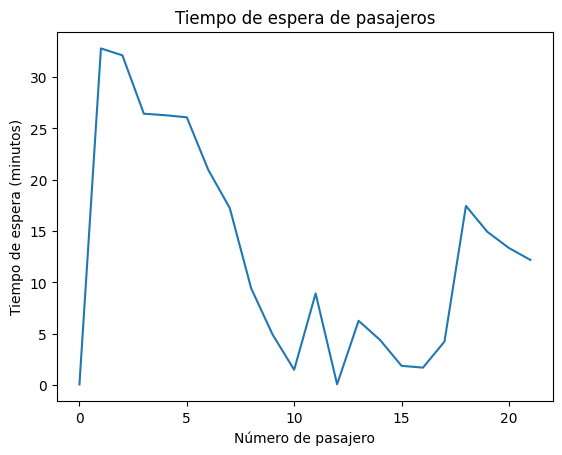

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import random
import simpy
import pandas as pd
import scipy.stats as st


# Parámetros del sistema de combis
tiempo_llegada_pasajeros = 5                 # Tasa de llegada de los pasajeros (1 cada 5 minutos)
tiempo_llegada_combis = 20                   # Tasa de llegada de combis (1 cada 20 minutos)
cap_combi = 19                               # Capacidad máxima de pasajeros de cada combi
tiempo_prom_abordo = 1 / 2                   # Tiempo promedio de abordo de cada pasajero (en minutos)

# Tiempo de simulación (en minutos)
tiempo_simulacion = 120

# Listas para almacenar datos
longitud_cola = []
tiempo_espera = []
tiempos_abordo = []
combis_necesarias = []  # Lista para la cantidad de combis necesarias

tiempos_espera_replicas = []
longitudes_cola_replicas = []
combis_necesarias_replicas = []

# Función para simular cuando los pasajeros llegan a la parada de combis.
def llegada_pasajeros(env, cola_pasajeros, tiempo_pasajero):
    numero_pasajero = 1  # Contador para identificar cada pasajero
    while True:
        # Tiempos de llegada de los pasajeros (distribución exponencial)
        tiempo_ll_pas = random.expovariate(1 / tiempo_llegada_pasajeros)
        yield env.timeout(tiempo_ll_pas)

        pasajero = f'--- El pasajero número {numero_pasajero}'
        print(f'{pasajero} llegó en el minuto {round(env.now, 2)}----')

        cola_pasajeros.put((pasajero, env.now))  # Guardamos el tiempo de llegada del pasajero
        tiempo_pasajero.append(env.now)  # Guardamos el tiempo de llegada del pasajero

        numero_pasajero += 1  # Incrementamos el contador de pasajeros

        # Actualizamos la longitud de la cola
        longitud_cola.append(len(cola_pasajeros.items))


def llegada_combis(env, cola_pasajeros, combis, tiempo_pasajero):
    numero_combi = 1  # Contador para identificar cada combi
    while True:
        # Tiempo de llegada de combis (distribución exponencial)
        tiempo_ll_com = random.expovariate(1 / tiempo_llegada_combis)
        yield env.timeout(tiempo_ll_com)

        combi = f' La combi número {numero_combi}'
        print(f'{combi} llegó en el minuto {env.now:.2f} ***')
        pasajeros = []
        tiempo_abordo_combi = 0

        # Las personas abordan la combi hasta que se llena
        while len(pasajeros) < cap_combi and len(cola_pasajeros.items) > 0:
            pasajero, tiempo_ll_pas = yield cola_pasajeros.get()  # Persona sube a la combi
            pasajeros.append(pasajero)
            tiempo_abordo_combi += random.expovariate(tiempo_prom_abordo)  # Tiempo de abordo de cada persona
            tiempo_espera_pasajero = env.now - tiempo_ll_pas
            tiempo_espera.append(tiempo_espera_pasajero)
            print(f'{pasajero} subió a {combi} después de {tiempo_espera_pasajero:.2f} minutos de espera +++')

        # La combi parte con los pasajeros
        combis.put(pasajeros)
        print(f'{combi} se fue con {len(pasajeros)} pasajeros <--.')

        # Registrar el tiempo de abordo promedio por combi
        tiempos_abordo.append(tiempo_abordo_combi / len(pasajeros) if pasajeros else 0)

        # Registrar la cantidad de combis necesarias
        combis_necesarias.append(len(pasajeros))
        numero_combi += 1  # Incrementar el ID de la combi


def simular():
    print("\n   XXXXXXXXXXXXX S  I  M  U  L  A  C  I  Ó  N XXXXXXXXXXXXX ")
    """Función principal para ejecutar la simulación."""
    env = simpy.Environment()
    cola_pasajeros = simpy.Store(env)  # Cola de personas
    combis = simpy.Store(env)  # Cola de combis
    tiempo_pasajero = []  # Para guardar el tiempo de llegada de cada persona

    # Arrancamos los procesos de llegada
    env.process(llegada_pasajeros(env, cola_pasajeros, tiempo_pasajero))
    env.process(llegada_combis(env, cola_pasajeros, combis, tiempo_pasajero))

    # Ejecutamos la simulación
    env.run(until=tiempo_simulacion)

    # Cálculos adicionales al finalizar la simulación
    promedio_tiempo_espera = np.mean(tiempo_espera) if tiempo_espera else 0
    promedio_longitud_cola = np.mean(longitud_cola) if longitud_cola else 0
    promedio_combis_necesarias = np.mean(combis_necesarias) if combis_necesarias else 0

    # Mostrar los resultados
    print("\n *********************************************************************************")
    print("\n---> Resultados de la simulación <---")
    print(f"Promedio del tiempo de espera de pasajeros: {promedio_tiempo_espera:.2f} minutos")
    print(f"Promedio de la longitud de la cola de pasajeros: {promedio_longitud_cola:.2f} personas")
    print(f"Promedio de pasajeros por combi: {promedio_combis_necesarias:.2f} pasajeros")

    # Calcular el número total de combis usadas en esta simulación
    total_combis_utilizadas = len(combis_necesarias)
    print(f"Número total de combis necesarias en esta ejecución: {total_combis_utilizadas}")

    print("\n *********************************************************************************")

    # Graficar el tiempo de espera de los pasajeros
    plt.figure()
    plt.plot(tiempo_espera)
    plt.xlabel("Número de pasajero")
    plt.ylabel("Tiempo de espera (minutos)")
    plt.title("Tiempo de espera de pasajeros")
    plt.show()

simular()
